In [82]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import scipy

In [2]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [3]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20181114_CEC_CAL-8-no4_MSpos_1,20181114_CEC_CAL-8-no4_MSpos_2,20181114_CEC_CAL-8-no4_MSpos_3,20181114_CEC_CAL-8-no4_MSpos_4,20181114_CEC_CAL-8-no4_MSpos_5,20181114_CEC_CAL-8-no4_MSpos_6,20181114_CEC_CAL-8-no4_MSpos_7,...,20181114_SR520-Creek_Mix6A_3,20181114_SR520-Creek_Mix6B_1,20181114_SR520-Creek_Mix6B_2,20181114_SR520-Creek_Mix6B_3,20181114_SwanCreek-Dec_1,20181114_SwanCreek-Dec_2,20181114_SwanCreek-Dec_3,20181114_SwanCreek-May_1,20181114_SwanCreek-May_2,20181114_SwanCreek-May_3
0,8.381,100.03931,60.33,0,0,0,0,0,0,0,...,68,82,100,0,0,0,0,0,0,0
1,2.332,100.07604,88.07,412,754,1985,1639,2049,1796,2702,...,674,1609,1571,782,976,729,587,6437,3174,2708
2,2.544,100.11243,111.09,4168,3547,2459,3768,3544,1695,2862,...,2282,1246,1662,2120,840,1336,1665,1200,1191,1217
3,5.359,100.11253,155.25,1239,1145,1007,550,1254,781,1714,...,203706,231624,152532,231635,260914,258902,234764,234498,193185,193974
4,0.628,101.00802,20.59,1295,1499,1508,2067,2103,2153,1500,...,18334,14693,11126,10754,14120,10229,12813,10449,9869,11369


In [4]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [5]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [6]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    '''
    The function is used to clean the dataframe according to user setting
    blank_keyword: part of string from column that indicates the column is a blank sample
    svb_thres: sample vs blank thres
    empty_thres: empty cell thres in a row
    cv_thres: as all sample is in triplicate, calculate the CV for every triplicate sample set #Needs to be updated in case there is no triplicate samples
    rt_range: rt filter
    mz_range: mz filter
    sn_thres: signal/noise column thres
    score_thres: score column thres
    area_thres: count for max peak area from each row
    '''
    drop_index = np.argwhere(np.asarray(d_input[d_input.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1) #Get the index for area thres filter
    d_thres = d_input.drop(drop_index[0])
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True)
    d_thres.drop(columns=['index'],inplace=True)
    
    col_blank = []
    for key in blank_keyword:
        col_app = [col for col in d_thres.columns if key in col] # Get column name if it contains blank indicating strings
        col_blank += col_app
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample] # Sample maximum area vs Blank average area to count for svb
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    # Get a list of triplicate, every triplicate is in a sublist
    #Sample: [[a1,a2,a3],[b1,b2,b3]]
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])] #Note: the triplicate parsing is now only used '_' which needs update in the future

    for triplicate in tqdm(trip_list):
        for index, row in d_sample[triplicate].iterrows(): # Loop for every sets of triplicates
            if (row == 0).sum() > empty_thres:
                d_sample.loc[index, triplicate] = 0 # if more than thres, then set all three values to 0
            elif row.std() / row.mean() > cv_thres:
                d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?
    #d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]
    
    
    return d_sample

In [7]:
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████| 10/10 [02:03<00:00, 12.30s/it]


In [83]:
def ms_cluster(d_input, select_keyword, normalization='linear', visual=False, d_reduce=True, d_reduce_method='tsne', perplexity=50, cluster_method='dbscan',eps=0.8,min_samples=10):
    '''
    Function for direct clustering:
    normalization method: linear, zscore, log
    d_reduce: if perform the dimension reduction algorithm, method: only tsne is avilable now
    perplexity: parameter for tsne
    cluster_method: dbscan, later will update optic and spectrum
    eps: parameter for dbscan, threshold of radius that used to count neighbours
    min_samples: general parameter for clustering, min neighbourhoods to be counted as a cluster
    '''
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    #Performs normalization
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    #Clean up dataframe
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            X=transformed.copy()
    elif d_reduce == False:
        X=d_norm.copy()
    
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)
        
        if visual == True:
            for i,k in enumerate(unique_labels):
                indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
                sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
                plt.title(str(dbscan)+'label='+ str(k))
                plt.show()

        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index] #Use the index to match back to the original datasheet
        d_label.insert(4,"label", dbscan.labels_.tolist())
    
    #Post filter -- filter out features that present in other sources but not SR520 -- keep it open for now
    #If activate add one more variable:source_keyword
#     col_source = []
#     for key in source_keyword:
#         col_app = [col for col in d_thres.columns if key in col]
#         col_source += col_app
#     col_rest = [col for col in d_label.columns if col not in source][5:]
#     d_label[col_app].max(1) / d_label[col_rest].max(1)
    
    return d_label

In [84]:
d_label = ms_cluster(d_sample,['SR520-Cal'],'linear',d_reduce=False,eps=0.6)

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


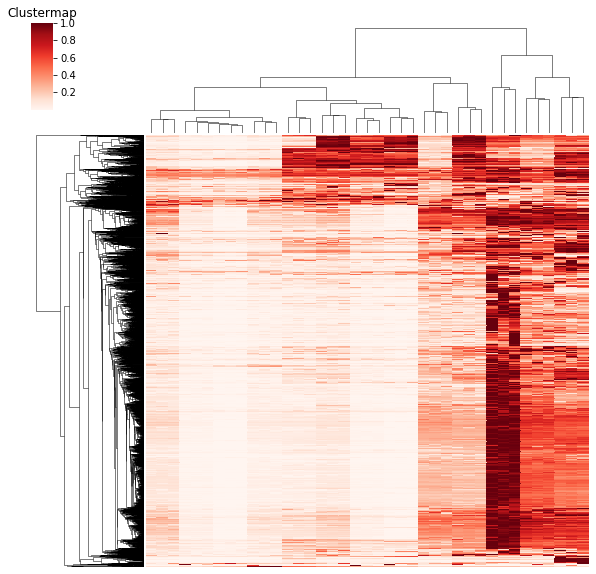

In [10]:
#no 0 is acceptable in the clustermap -- eye balling estimation?
sns.clustermap(d_norm.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

In [12]:
# options: all_data/clusters seperately
# models: multiple linear/ random forest/ etc..
# def modeling:
#     select option
#     select model
#     if option all_data:
#         model.fit(data) --> training 1114data, test 0815data
#     elif option cluster:
#         for group in cluster:
#             model.fit(group)
#         all_model -- > final_model

In [13]:
# post filtering of dilution cluster
# source tracking:
#     1. samples from different sites
#     2. vann diagram--> 'source subtraction' --> unique features for different source
#     3. use cluster/noise distinguish method --> remove noises, get clusters
#     4. source proportioning prediction 

In [20]:
d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
d_norm = d_norm.dropna()
d_norm = d_norm.reset_index(drop=True)

# Trend Clustering Method 

In [78]:
def trend_calc(d_input, select_keyword, min_size=5, normalization='linear', visual=True):
    """This function calculates clustering based on the pearson correlation.
    It takes in a dataframe and a user defined value for what qualifies as a cluster.
    User can choose whether or not to have a visual plot of the scatter with True/False."""
    col_select = []
    for key in select_keyword:
        col_app = [col for col in d_input.columns if key in col]
        col_select += col_app
    d_clu = d_input[col_select]
    
    c_data = d_clu.values
    c_norm = []
    for row in c_data:
        if normalization == 'linear':
            c_norm.append(row/max(row))
        elif normalization == 'zscore':
            c_norm.append((row-np.mean(row))/np.std(row))
        elif normalization == 'log':
            row[row==0]=1
            c_norm.append(np.log10(row)/np.log10(max(row)))
    c_norm = np.asarray(c_norm)
    d_norm = pd.DataFrame(c_norm)
    d_norm['index']=d_sample.index
    d_norm.set_index('index',inplace=True)
    d_norm.dropna(how='all',inplace=True)
    
    #Post treatment to fit the d_norm into original codes
    d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
    d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
    d_norm = d_norm.reset_index(drop=True)
    
    
    #Original codes
    cluster = [] # individual cluster holder
    cluster_sum = [] # total clusters
    drop_list = [] # rows that are dropped from the df
    noise = [] # list for containing noise features
    while len(d_norm) > 0:
        for row in range(len(d_norm)):
            feature_1 = d_norm.iloc[0]
            feature_2 = d_norm.iloc[row]
            corr, p_val = scipy.stats.pearsonr(d_norm.iloc[0, 2:], d_norm.iloc[row, 2:]) #Potentially you can take the 2: off as d_norm.iloc[0] vs d_norm.iloc[row] 
            #And keep the index the same but not reset it, so you can use the index to link back to the d_input
            if p_val < 0.05:
                drop_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) <= min_size:
            noise += [cluster]
            cluster = []
        else:
            cluster_sum += [cluster]
            cluster = []
        d_norm = d_norm.drop(drop_list)
        d_norm = d_norm.reset_index(drop=True)
        drop_list = []
    append_list = []
    for i in range(len(cluster_sum)):
        for j in range(len(cluster_sum[i])):
            cluster_sum[i][j].loc['Score']= i
            listing = np.array(cluster_sum[i][j])
            append_list.append(listing)
    cluster_df = pd.DataFrame(append_list) #Add columns use d_clu
    append_list2 = []
    for k in range(len(noise)):
        for l in range(len(noise[k])):
            noise[k][l].loc['Score']= -1
            listing2 = np.array(noise[k][l])
            append_list2.append(listing2)
    noise_df = pd.DataFrame(append_list2)
    final_df = pd.concat([cluster_df, noise_df])
    final_df = final_df.reset_index(drop=True)
    if visual == True:
        labels = final_df.iloc[:,-1:].values.reshape(1,-1)[0]
        unique_labels = set(labels)
        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(final_df.iloc[indexlist,2:-1].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title('trend'+'label='+ str(k))
            plt.show()
    else:
        pass
    return final_df

# Running Trend Cluster Algorithm

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


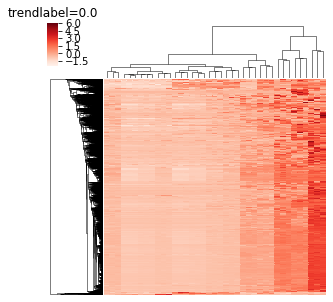

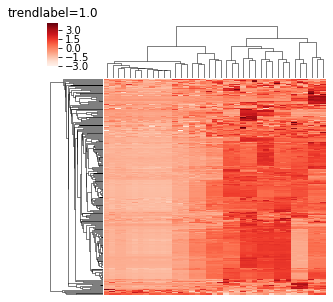

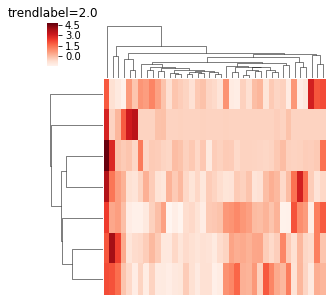

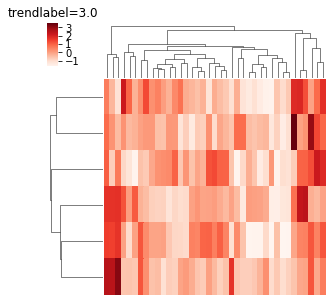

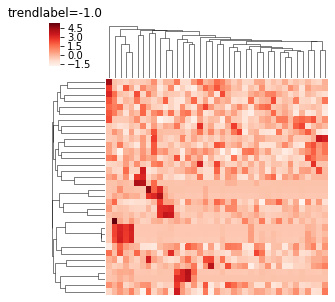

In [80]:
d_1=trend_calc(d_sample, ['SR520-Cal'], min_size=5, normalization='zscore', visual=True)